# Predicting average trip length for a day

## Setup

We import relevant packages, perform setup work, and log in to Darwin.

In [1]:
from IPython.display import Image
from time import sleep
from sklearn.metrics import r2_score
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
ts = '{:%Y%m%d%H%M%S}'.format(datetime.now())

In [2]:
from amb_sdk.sdk import DarwinSdk
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')

# Logging in to Darwin.
status, msg = ds.auth_login_user('nathanalvarezolson@utexas.edu', 'Hmy35qPZM4')
print('You are logged in.' if status else msg)

You are logged in.


## Data Preparation
Reading the BCycle / weather dataset. We trim some outliers, and save the new, edited dataset. We upload this dataset to Darwin.

In [3]:
#Reading the dataset and shwoing the head so as to be confident.
DATASET_NAME = 'cycle_weather_by_day_with_avgs_no_mode.csv'

df = pd.read_csv('./data/'+ DATASET_NAME)
df.head()

,Date,Month,Year,Weekday,Avg Trip Duration,Total Rides,TempHighF,TempAvgF,DewPointHighF,DewPointAvgF,WindHighMPH,WindAvgMPH,PrecipitationSumInches,Events,PrecipBins
0,2013-12-21,12,2013,5,29.136,103,74,60,67,49,20,4,0.460,"Rain , Thunderstorm",0.1-0.5
1,2013-12-22,12,2013,6,40.462,117,56,48,43,36,16,6,0.000,Sunny,0
2,2013-12-23,12,2013,0,55.604,96,58,45,31,27,8,3,0.000,Sunny,0
3,2013-12-24,12,2013,1,31.965,85,61,46,36,28,12,4,0.000,Sunny,0
4,2013-12-25,12,2013,2,49.297,145,58,50,44,40,10,2,0.005,Sunny,0.1-0.5


In [4]:
# Trimming the outliers. Namely, we trim the days which have an average trip duration longer than an hour.
# These data points had very negatively impacted our model's predictive power previously.
df = df[df['Avg Trip Duration'] <= 60]

df.head()

,Date,Month,Year,Weekday,Avg Trip Duration,Total Rides,TempHighF,TempAvgF,DewPointHighF,DewPointAvgF,WindHighMPH,WindAvgMPH,PrecipitationSumInches,Events,PrecipBins
0,2013-12-21,12,2013,5,29.136,103,74,60,67,49,20,4,0.460,"Rain , Thunderstorm",0.1-0.5
1,2013-12-22,12,2013,6,40.462,117,56,48,43,36,16,6,0.000,Sunny,0
2,2013-12-23,12,2013,0,55.604,96,58,45,31,27,8,3,0.000,Sunny,0
3,2013-12-24,12,2013,1,31.965,85,61,46,36,28,12,4,0.000,Sunny,0
4,2013-12-25,12,2013,2,49.297,145,58,50,44,40,10,2,0.005,Sunny,0.1-0.5


In [5]:
# We save the new, edited dataset.
df.to_csv('./data/' + 'cycle_weather_by_day_with_avgs_no_mode_trimmed.csv', index = False)

In [6]:
# Uploading the dataset to Darwin. Oftentimes this will not work, as the dataset has already been uploaded.

#df.drop(columns='Avg Mode Trip Duration', inplace = True)
DATASET_NAME = 'cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'
status, dataset = ds.upload_dataset('./data/'+ DATASET_NAME)
if not status:
    print(dataset)

400: BAD REQUEST - {"message": "Dataset already exists"}



## Data cleaning
Cleaning data with Darwin.

In [7]:
# We aim to predict the average trip duration for a day. As such, we set this as the target column.
target = 'Avg Trip Duration'
status, job_id = ds.clean_data(dataset_name=DATASET_NAME, 
                               target= target)
if not status:
    print(job_id)
else:
    ds.wait_for_job(job_id['job_name'])
    print('\nData has been successfully cleaned!')

{'status': 'Requested', 'starttime': '2019-04-22T13:18:57.436163', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': ['f72a71233be74804b8ce1b89fa0e9f29'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T13:18:57.436163', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': ['f72a71233be74804b8ce1b89fa0e9f29'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T13:18:57.436163', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': ['f72a71233be74804b8ce1b89fa0e9f29'], 'model_name': None, 'j

## Model creation and training

We build a model that will learn the class labels in the target column. We train for 3 minutes, which we found to be the optimal length. Training for longer (on this dataset) often resulted in overfitting.

In [8]:
model = target + "_model0" + ts
status, job_id = ds.create_model(dataset_names = DATASET_NAME, \
                                 model_name =  model, \
                                 max_train_time = '00:03')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-22T13:21:49.924512', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': None, 'model_name': 'Avg Trip Duration_model020190422131843', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T13:21:49.924512', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': None, 'model_name': 'Avg Trip Duration_model020190422131843', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T13:21:49.924512', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': None, 'model_name': 'Avg Trip Duration_model020190422131843', 'job_err

{'status': 'Running', 'starttime': '2019-04-22T13:21:49.924512', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': None, 'model_name': 'Avg Trip Duration_model020190422131843', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T13:21:49.924512', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': None, 'model_name': 'Avg Trip Duration_model020190422131843', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T13:21:49.924512', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': None, 'model_name': 'Avg Trip Duration_model020190422131843', 'job_error': ''}
{

## Model analysis

Darwin analyszes the model, and reports which features have a larger impact on the model.

In [9]:
# We analyze the model Darwin built
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Requested', 'starttime': '2019-04-22T13:31:46.79585', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.43536823987960815, 'generations': 2, 'dataset_names': None, 'artifact_names': ['096fa0566d1d4388a87a992f12b28df7'], 'model_name': 'Avg Trip Duration_model020190422131843', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T13:31:46.79585', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.43536823987960815, 'generations': 2, 'dataset_names': None, 'artifact_names': ['096fa0566d1d4388a87a992f12b28df7'], 'model_name': 'Avg Trip Duration_model020190422131843', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T13:31:46.79585', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.43536823987960815, 'generations': 2, 'dataset_names': None, 'artifact_names': ['096fa0566d1d4388a87a992f12b28df7'], 'model_name': 'Avg Trip Duration_model020190422131843', 'job_error': N

In [10]:
# Showing the 10 most important features of the model.
print('The most important features are:')
print(feature_importance[:10])

The most important features are:
Total Rides    0.404770
Weekday = 6    0.170303
TempHighF      0.108483
Weekday = 5    0.106555
TempAvgF       0.041221
Year = 2015    0.032943
Weekday = 4    0.014495
Month = 5      0.012262
Month = 9      0.011773
WindHighMPH    0.011214
dtype: float64


## Predictions
In creating the model, Darwin previously withheld a portion of the dataset for testing. We use our model to predict the target column label (in this case, average trip length) on this testing set. We then download the predictions from Darwin's server.

In [12]:
status, artifact = ds.run_model(DATASET_NAME, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Requested', 'starttime': '2019-04-22T13:47:55.147976', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.43536823987960815, 'generations': 2, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': ['d478d882f625443d82796a9301ef14a7'], 'model_name': 'Avg Trip Duration_model020190422131843', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T13:47:55.147976', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.43536823987960815, 'generations': 2, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': ['d478d882f625443d82796a9301ef14a7'], 'model_name': 'Avg Trip Duration_model020190422131843', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T13:47:55.147976', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.43536823987960815, 'generations': 2, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_

{'status': 'Requested', 'starttime': '2019-04-22T13:47:55.147976', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.43536823987960815, 'generations': 2, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': ['d478d882f625443d82796a9301ef14a7'], 'model_name': 'Avg Trip Duration_model020190422131843', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T13:47:55.147976', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.43536823987960815, 'generations': 2, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': ['d478d882f625443d82796a9301ef14a7'], 'model_name': 'Avg Trip Duration_model020190422131843', 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-22T13:47:55.147976', 'endtime': '2019-04-22T13:53:51.105775', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.43536823987960815, 'generations': 2, 'dataset_names': ['cycle_weather_

(True, 'Job completed')

In [13]:
# Downloading predictions
status, prediction = ds.download_artifact(artifact['artifact_name'])

## Model accuracy
We create a plot to compare the predicted label  with the actual label. We also get the $R^2$ score.

R^2 :  0.6383875831312176


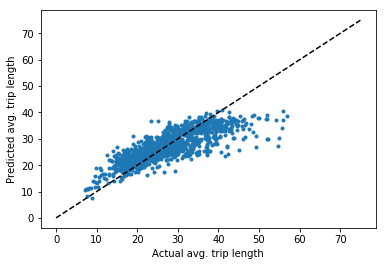

In [15]:
#Plot predictions vs actual
plt.plot(df[target], prediction[target], '.')
plt.plot([0,75],[0,75],'--k')
plt.xlabel('Actual avg. trip length')
plt.ylabel('Predicted avg. trip length')
print('R^2 : ', r2_score(df[target], prediction[target]))

In [24]:
# We print the best parameters
status, model_type = ds.lookup_model_name(model)
print('Our model was of type:', model_type['description']['best_genome']['type'])
print('Our best parameters were:', '\n')

for parameter in model_type['description']['best_genome']['parameters']:
    print(parameter, ':', model_type['description']['best_genome']['parameters'][parameter])

Our model was of type: XGBRegressor
Our best parameters were: 

base_score : 0.5
colsample_bylevel : 1
colsample_bytree : 1
gamma : 0
learning_rate : 0.1
max_delta_step : 0
max_depth : 3
min_child_weight : 1
n_estimators : 100
n_jobs : -1
reg_alpha : 0
reg_lambda : 1
scale_pos_weight : 1
subsample : 1.0


In [ ]:
# This cell can be used to delete the model, in the case that Darwin fails and needs to be run again.
ds.delete_model(model)